In [56]:
%load_ext autoreload
%autoreload 2
import numpy as np
import igraph
import matplotlib.pyplot as plt

from spring_embedding_models import SpringEmbeddingModel, SpringEmbeddingGenerativeModel, SpringAttentionGenerativeModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def visualize_graph_from_matrix(A, node_positions, node_classes=None, ax=None):
    """
    Visualizes the graph using igraph.
    """

    
    g = igraph.Graph.Adjacency(A.tolist())
    g.vs['label'] = [str(i) for i in range(len(g.vs))]

    # adjust edge display properties for visibility
    g.es["curved"] = 0.2

    # set node and edge colors based on classes
    if node_classes is not None:
        unique_classes = sorted(set(node_classes))
        class_to_color = {cls: plt.cm.tab10(i) for i, cls in enumerate(unique_classes)}
        g.vs['color'] = [class_to_color[cls] for cls in node_classes]
        edge_colors = []
        for e in g.es:
            source = e.source
            cls = node_classes[source]
            edge_colors.append(class_to_color[cls])
        g.es["color"] = edge_colors

    layout = igraph.Layout(node_positions)
    if ax is None:
        ax = plt.gca()
    igraph.plot(
        g, 
        layout=layout, 
        vertex_label=g.vs['label'],  
        vertex_size=20,
        target=ax
    )

In [4]:
test_embeddings = np.array([
    [1, 1.5],
    [1.7, 1],
    [2, 2],
    [-1.5, -1],
    [-1, -1.7],
    [-2, -2]
])

In [5]:
gen_model = SpringEmbeddingModel(node_embeddings=test_embeddings)
gen_model_low_temp = SpringEmbeddingModel(node_embeddings=test_embeddings, beta=5)
gen_model_uncoupled = SpringEmbeddingModel(node_embeddings=test_embeddings, alpha=0.01, beta=5)
gen_model_coupled = SpringEmbeddingModel(node_embeddings=test_embeddings, alpha=10, beta=5)

In [7]:
A = np.zeros((6, 6))
for i in range(1000):
    A += gen_model_low_temp.generate(12)
A / 1000

array([[0.   , 0.027, 0.   , 0.18 , 0.121, 0.003],
       [0.149, 0.   , 0.   , 0.293, 0.172, 0.011],
       [0.685, 0.658, 0.   , 0.79 , 0.68 , 0.196],
       [0.204, 0.135, 0.009, 0.   , 0.024, 0.   ],
       [0.308, 0.185, 0.006, 0.151, 0.   , 0.   ],
       [0.682, 0.699, 0.197, 0.684, 0.643, 0.   ]])

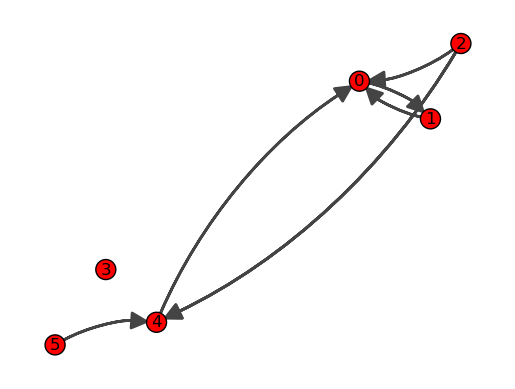

In [9]:
gen_net = gen_model.generate(expected_num_edges=12)
visualize_graph_from_matrix(gen_net, test_embeddings)

# experiments on parameters:
- beta is inverse temperature
- k controls sparsity
- alpha controls how coupled the ranking vs. community structure is

Can we fit this separately, first as SpringRank to get $r_{ij}$ values and then learn the cosine distances $c_{ij}$ from there.

GOAL: given a generated network, can we recover the parameters by fitting the model?

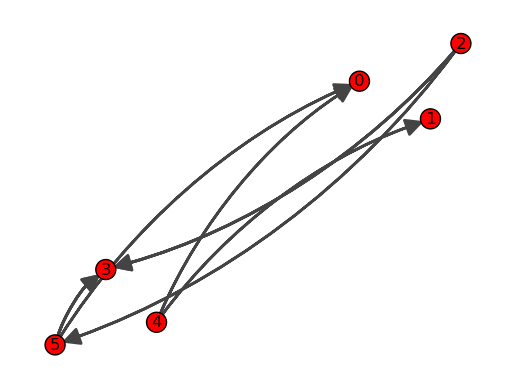

In [18]:
gen_net = gen_model_low_temp.generate(expected_num_edges=12)
visualize_graph_from_matrix(gen_net, test_embeddings)

In [22]:
gen_model_low_temp._decay_factor(2, 3)

0.5024392577228333

In [24]:
gen_model_low_temp._spring_force(2, 3), gen_model_low_temp._spring_force(3, 2)

(0.00032899939301972604, 2.0516319734214115)

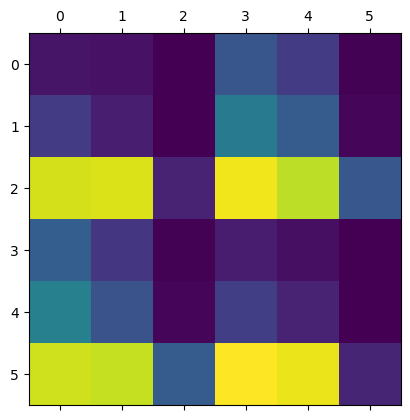

In [20]:
A = np.zeros((6, 6))
for i in range(1000):
    A += gen_model_low_temp.generate(12, allow_self_loops=True)
plt.matshow(A)

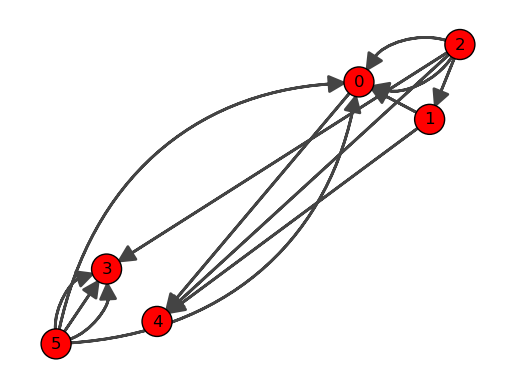

In [60]:
gen_net = gen_model_uncoupled.generate(expected_num_edges=12)
visualize_graph_from_matrix(gen_net, test_embeddings)

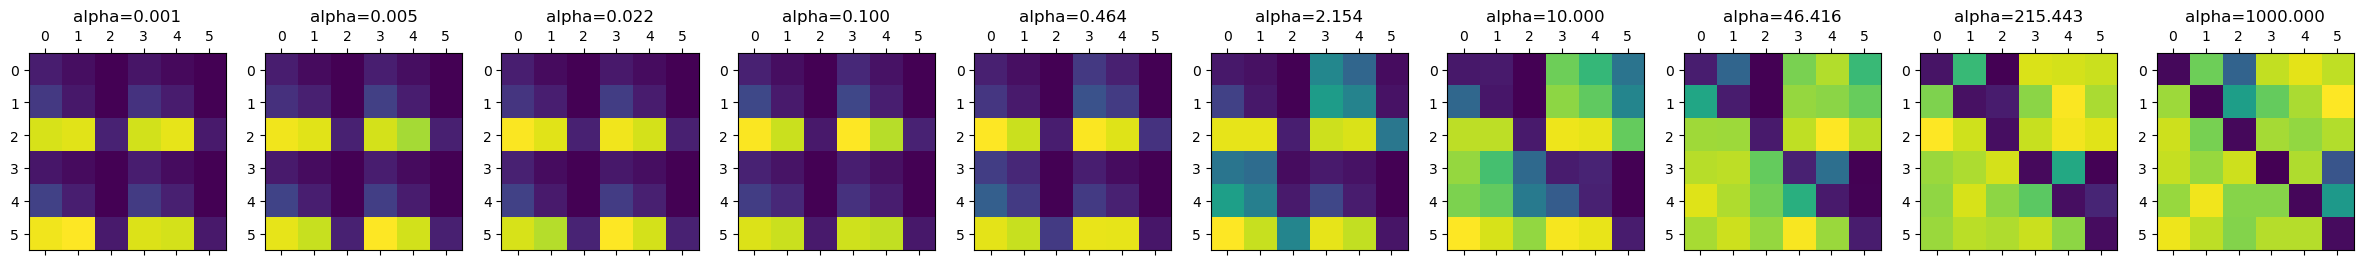

In [31]:
alphas = np.logspace(-3, 3, 10, base=10)
n = len(alphas)
fig, axs = plt.subplots(1, n, figsize=(n * 3, 3))
for i, alpha in enumerate(alphas):
    gen_model = SpringEmbeddingModel(node_embeddings=test_embeddings, alpha=alpha, beta=5)
    A = np.zeros((6, 6))
    for j in range(1000):
        A += gen_model.generate(12, allow_self_loops=True)
    axs[i].matshow(A)
    axs[i].set_title(f'alpha={alpha:.3f}')

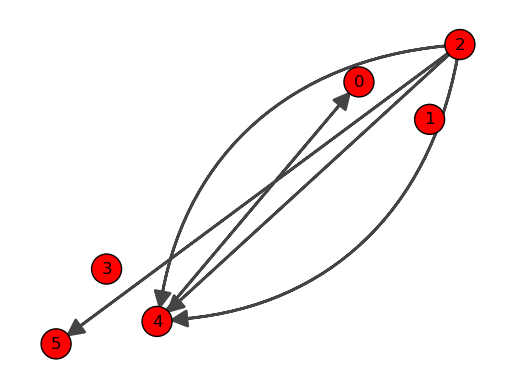

In [61]:
gen_net = gen_model_coupled.generate(expected_num_edges=12)
visualize_graph_from_matrix(gen_net, test_embeddings)

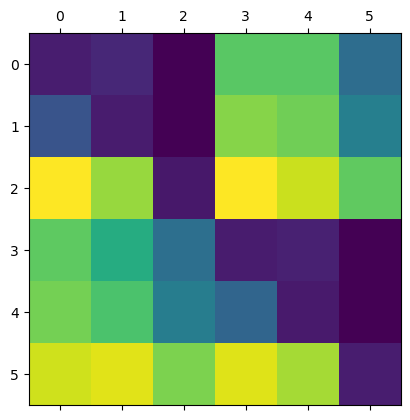

In [25]:
A = np.zeros((6, 6))
for i in range(1000):
    A += gen_model_coupled.generate(12, allow_self_loops=True)
plt.matshow(A)

In [7]:
# test embeddings for attention model
jocks_goths_status = np.array([
    [4, 0], # jocks
    [3, 0],
    [2, 0],
    [1, 0],
    [-4, 0], # goths
    [-3, 0],
    [-2, 0],
    [-1, 0]
])
jocks_goths_prefs = jocks_goths_status.copy()
classes = [0, 0, 0, 0, 1, 1, 1, 1]

In [ ]:
gen_attention_model = SpringAttentionGenerativeModel(X=jocks_goths_prefs, Y=jocks_goths_status, beta=1, alpha=10)

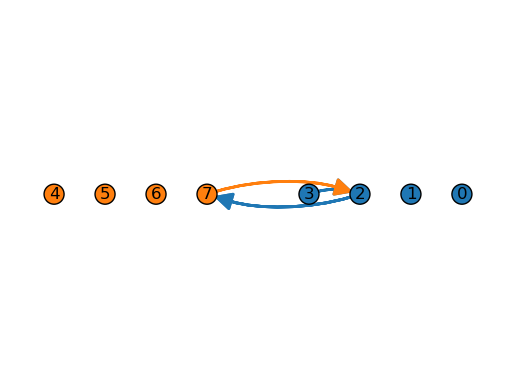

In [9]:
gen_net = gen_attention_model.generate(expected_num_edges=8)
visualize_graph_from_matrix(gen_net, jocks_goths_status, classes)

[884.0, 2534.0] [2379.0, 840.0]


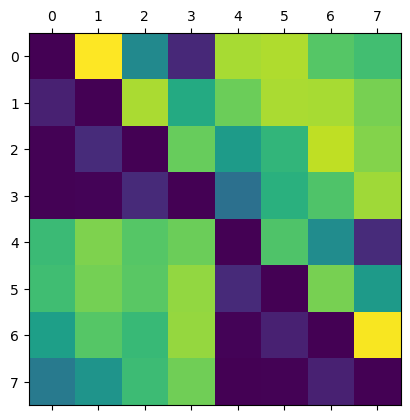

In [11]:
A = np.zeros((8, 8))
for i in range(1000):
    A += gen_attention_model.generate(expected_num_edges=8)
plt.matshow(A)
print([A[:4, :4].sum(), A[:4, 4:].sum()], [A[4:, :4].sum(), A[4:, 4:].sum()])

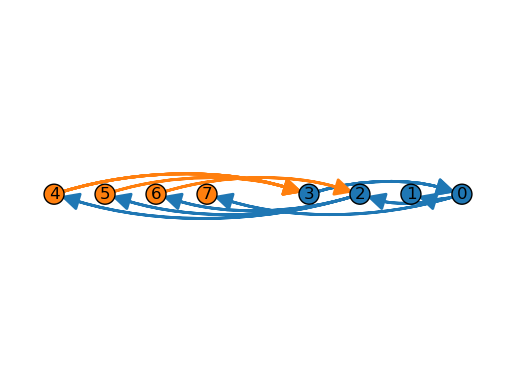

In [12]:
# try changing a few preferences
jocks_goths_prefs2 = jocks_goths_prefs.copy()
jocks_goths_prefs2[0] = [0, 1] # queen of the jocks has orthogonal preference
gen_attention_model2 = SpringAttentionModel(X=jocks_goths_prefs2, Y=jocks_goths_status, beta=1, alpha=10)
gen_net = gen_attention_model2.generate(expected_num_edges=8)
visualize_graph_from_matrix(gen_net, jocks_goths_status, classes)

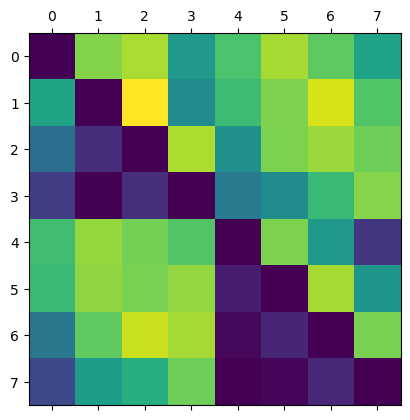

In [13]:
A = np.zeros((8, 8))
for i in range(1000):
    A += gen_attention_model2.generate(expected_num_edges=8)
plt.matshow(A)

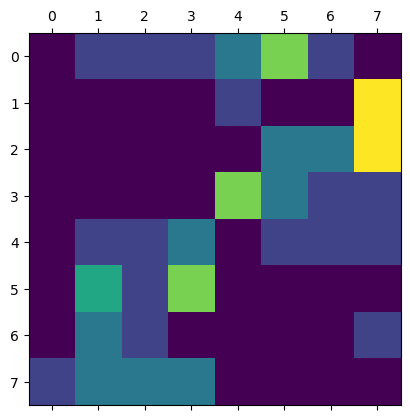

In [84]:
# generate synthetic data
synth_embeddings = np.array([
    [2, 2],
    [1, 1.5],
    [1.5, 1],
    [1, 1],
    [-2, -2],
    [-1.5, -1],
    [-1, -1.5],
    [-1, -1]
])
communities = np.array([0, 0, 0, 0, 1, 1, 1, 1])
synth_model = SpringEmbeddingGenerativeModel(synth_embeddings, alpha=1, beta=5)
A = synth_model.generate(expected_num_edges=80)
plt.matshow(A)

In [64]:
inference_model = SpringEmbeddingModel(A, alpha=1, beta=5)
inference_model.fit()

  2%|▏         | 238/10000 [00:00<00:12, 754.35it/s]

Iteration 100, Acceptance rate: 0.8280, Proposal variance: 0.110000, Beta: 0.5952, Energy: 7.2507
Iteration 200, Acceptance rate: 0.8137, Proposal variance: 0.121000, Beta: 1.0905, Energy: 5.5580


  4%|▍         | 392/10000 [00:00<00:13, 703.50it/s]

Iteration 300, Acceptance rate: 0.7900, Proposal variance: 0.133100, Beta: 1.5857, Energy: 4.6221
Iteration 400, Acceptance rate: 0.7450, Proposal variance: 0.146410, Beta: 2.0810, Energy: 3.9646


  6%|▌         | 617/10000 [00:00<00:12, 735.05it/s]

Iteration 500, Acceptance rate: 0.7438, Proposal variance: 0.161051, Beta: 2.5762, Energy: 4.5672
Iteration 600, Acceptance rate: 0.7188, Proposal variance: 0.177156, Beta: 3.0715, Energy: 4.9389


  8%|▊         | 774/10000 [00:01<00:12, 742.70it/s]

Iteration 700, Acceptance rate: 0.6737, Proposal variance: 0.194872, Beta: 3.5667, Energy: 6.4231
Iteration 800, Acceptance rate: 0.6262, Proposal variance: 0.214359, Beta: 4.0620, Energy: 9.6923


 10%|█         | 1008/10000 [00:01<00:11, 765.68it/s]

Iteration 900, Acceptance rate: 0.6138, Proposal variance: 0.235795, Beta: 4.5572, Energy: 3.5550
Iteration 1000, Acceptance rate: 0.5938, Proposal variance: 0.259374, Beta: 5.0525, Energy: 5.9391


 12%|█▏        | 1245/10000 [00:01<00:11, 756.64it/s]

Iteration 1100, Acceptance rate: 0.5625, Proposal variance: 0.285312, Beta: 5.5477, Energy: 4.0901
Iteration 1200, Acceptance rate: 0.5375, Proposal variance: 0.313843, Beta: 6.0430, Energy: 4.0850


 14%|█▍        | 1402/10000 [00:01<00:11, 763.99it/s]

Iteration 1300, Acceptance rate: 0.4825, Proposal variance: 0.345227, Beta: 6.5382, Energy: 7.3779
Iteration 1400, Acceptance rate: 0.4800, Proposal variance: 0.379750, Beta: 7.0335, Energy: 6.6739


 16%|█▋        | 1634/10000 [00:02<00:11, 758.18it/s]

Iteration 1500, Acceptance rate: 0.4525, Proposal variance: 0.417725, Beta: 7.5287, Energy: 2.9777
Iteration 1600, Acceptance rate: 0.4062, Proposal variance: 0.459497, Beta: 8.0240, Energy: 2.6377


 18%|█▊        | 1793/10000 [00:02<00:10, 777.81it/s]

Iteration 1700, Acceptance rate: 0.4037, Proposal variance: 0.505447, Beta: 8.5192, Energy: 4.3144
Iteration 1800, Acceptance rate: 0.3475, Proposal variance: 0.555992, Beta: 9.0145, Energy: 3.2705


 20%|██        | 2029/10000 [00:02<00:10, 765.99it/s]

Iteration 1900, Acceptance rate: 0.3638, Proposal variance: 0.611591, Beta: 9.5097, Energy: 3.2490


100%|██████████| 10000/10000 [00:12<00:00, 803.89it/s]

Final acceptance rate: 0.2502
Final energy: 3.2451


array([[-14.48817081,   3.0969625 ],
       [  4.31480833,  -0.87518423],
       [  1.67443996,  -0.30583138],
       [  3.79984911,  -0.61744126],
       [-13.77209169,   3.10514541],
       [-14.14850505,   2.53970538],
       [  3.3260148 ,  -0.91827401],
       [-13.54782506,   2.77271264]])

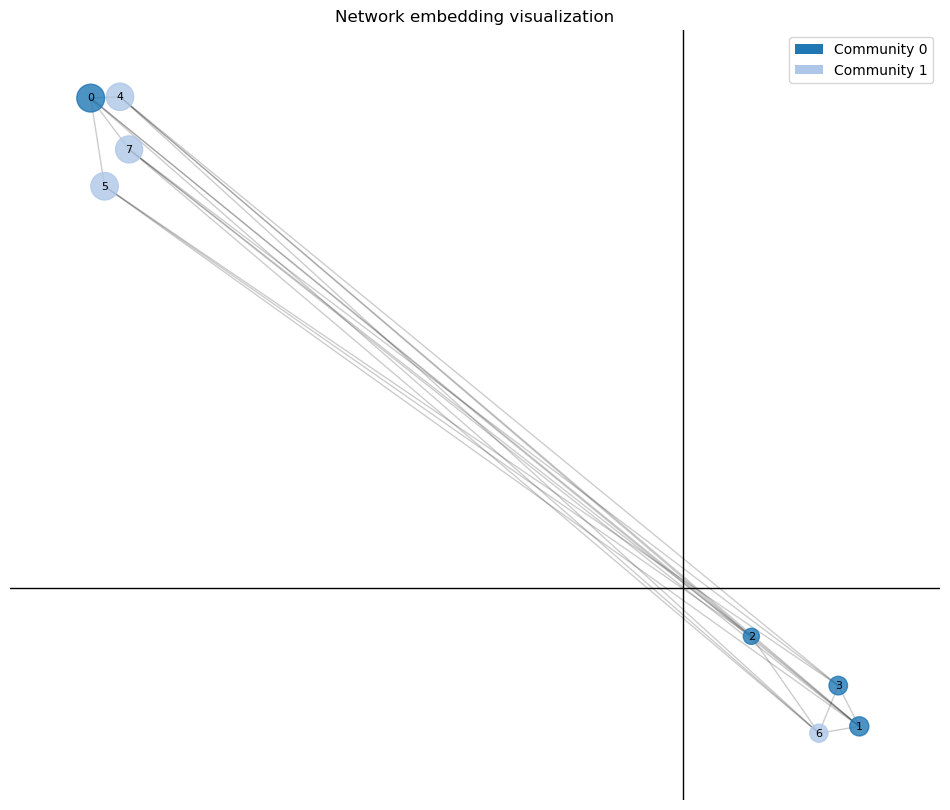

In [85]:
inference_model.visualize(communities=communities)